<img src = "https://oma.astrofisicamas.cl/wp-content/uploads/2021/11/LOGO-USM.png" title = "Title text" width = "60%" height = "60%" />


<hr style="height:1px;border:none"/>
<h1 align='center'> MAT279 - Optimización No Lineal</h1>

<h1 align='center'> Tarea 8  </h1>
<H3 align='center'> Estudiante: Pablo Calcumil Alarcón</H3>
<H3 align='center'> Profesor: Julio Deride Silva</H3>
<hr style="height:1px;border:none"/>

La siguiente tarea consistirá en tratar el problema de la regresión logística.

En este problema se tiene una variable aleatoria $Y \in \{0,1\}$, y un vector aleatorio $p-$dimensional de covariables. Donde una forma de modelar $Y$ utilizando la información $X$ es la siguiente:

$$p(x) = \mathbb{P}(Y=1 | X = x)$$

Donde al introducir modelos paramétricos, digamos $p(x) = p_0(x;\beta)$, el modelo de regresión logística, consiste en utilizar la función logística como modelo paramétrico, es decir:

$$p_0(x; \beta) = \frac{1}{1+\exp(-x^T \beta)}$$

donde se tratará de estimar el vector $\beta$, utilizando la máxima verosimilitud, donde el estimador se obtiene mediante la resolución del siguiente problema:

\begin{equation}
\min_{\beta \in \mathbb{R}^d} \ell(\beta) = \sum_{i=1}^N y_i \cdot \ln\left[p_0(x_i;\beta)\right] + (1-y_i)\cdot\ln\left[1 - p_0(x_i;\beta)\right]
\end{equation}

Para este problema se utilizarán los métodos de regularización _Ridge_ ($\varphi_\lambda = \lambda||\cdot||_2^2$) y _Lasso_ ($\varphi_\lambda = \lambda||\cdot||_1$), donde el problema final a resolver es el siguiente:


\begin{equation}
\min_{\beta \in \mathbb{R}^d} \ell(\beta) + \varphi_{\lambda}(\beta)
\end{equation}

## Pequeño Análisis Exploratorio

In [1]:
from numpy import exp
from numpy import log as ln
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Se abre el conjunto de datos .data
df = pd.read_csv('ionosphere.data', sep = ',')

#Formamos las columnas, para no perder el primer dato
row = list(df.columns)
first_row = []

#Solucionamos el problema donde se agrega un .1 por valor columna repetido
#y convertimos en float los valores de columna, pues pasaban a ser string
#al ser parte de las columnas
for numero in row[: -1]:
    if len(numero) > 1:
        if numero[-2] == '.':
            first_row.append(float(numero[: -2]))
        else:
            first_row.append(float(numero))
    else:
        first_row.append(float(numero))

#Agregamos el ultimo valor que si es string
first_row.append(row[-1])        

#Formamos nuevos nombres de las columnas
largo = len(first_row)
columnas = ['x_' + str(i) for i in range(1, largo)] + ['target']

#Agregamos el primer dato al dataframe
df = list(df.to_numpy())
df.insert(0, first_row)
df = pd.DataFrame(data = df, columns = columnas)

#Cambiamos valores categoricos del target a valores binarios: g --> 1 ; b --> 0
df['target'] = df['target'].replace({'g' : 1, 'b' : 0})

#Visualizamos dataframe
df.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,target
0,1.0,0.0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1.0,0.0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1.0,0.0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1.0,0.0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1.0,0.0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1



Distribución de las variables


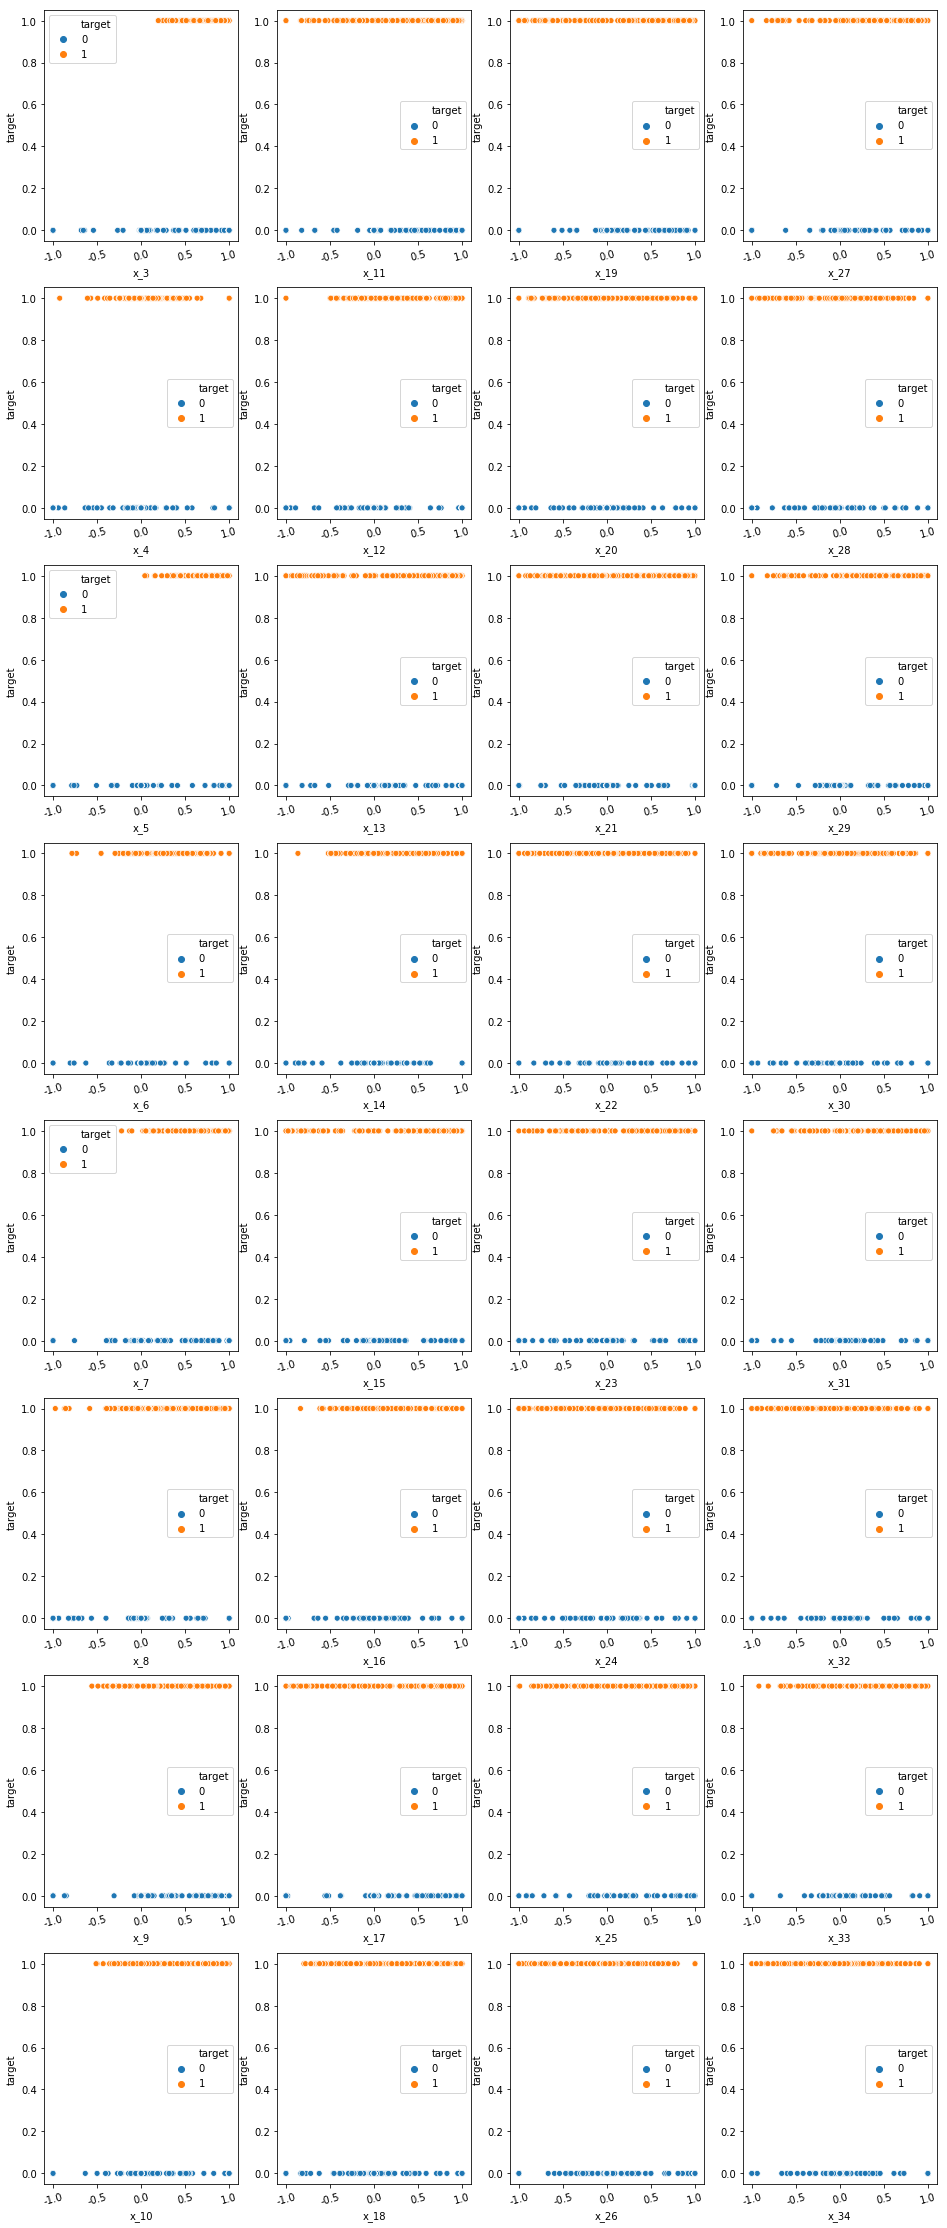

In [3]:
#Columnas de datos 'x_1' y 'x_2' no se incluyen por ser obvias
cols = list(df.columns[2:-1])

print('\nDistribución de las variables')

fig, ax = plt.subplots(8, 4, figsize = (16, 40))

for i in range(0, 8):
    for j in range(0, 4):
        sns.scatterplot(data = df, x = cols[8 * j + i], y = 'target', hue = 'target', ax = ax[i][j])
        ax[i][j].set_xticklabels(ax[i][j].get_xticks(), rotation = 15)
    
plt.show()

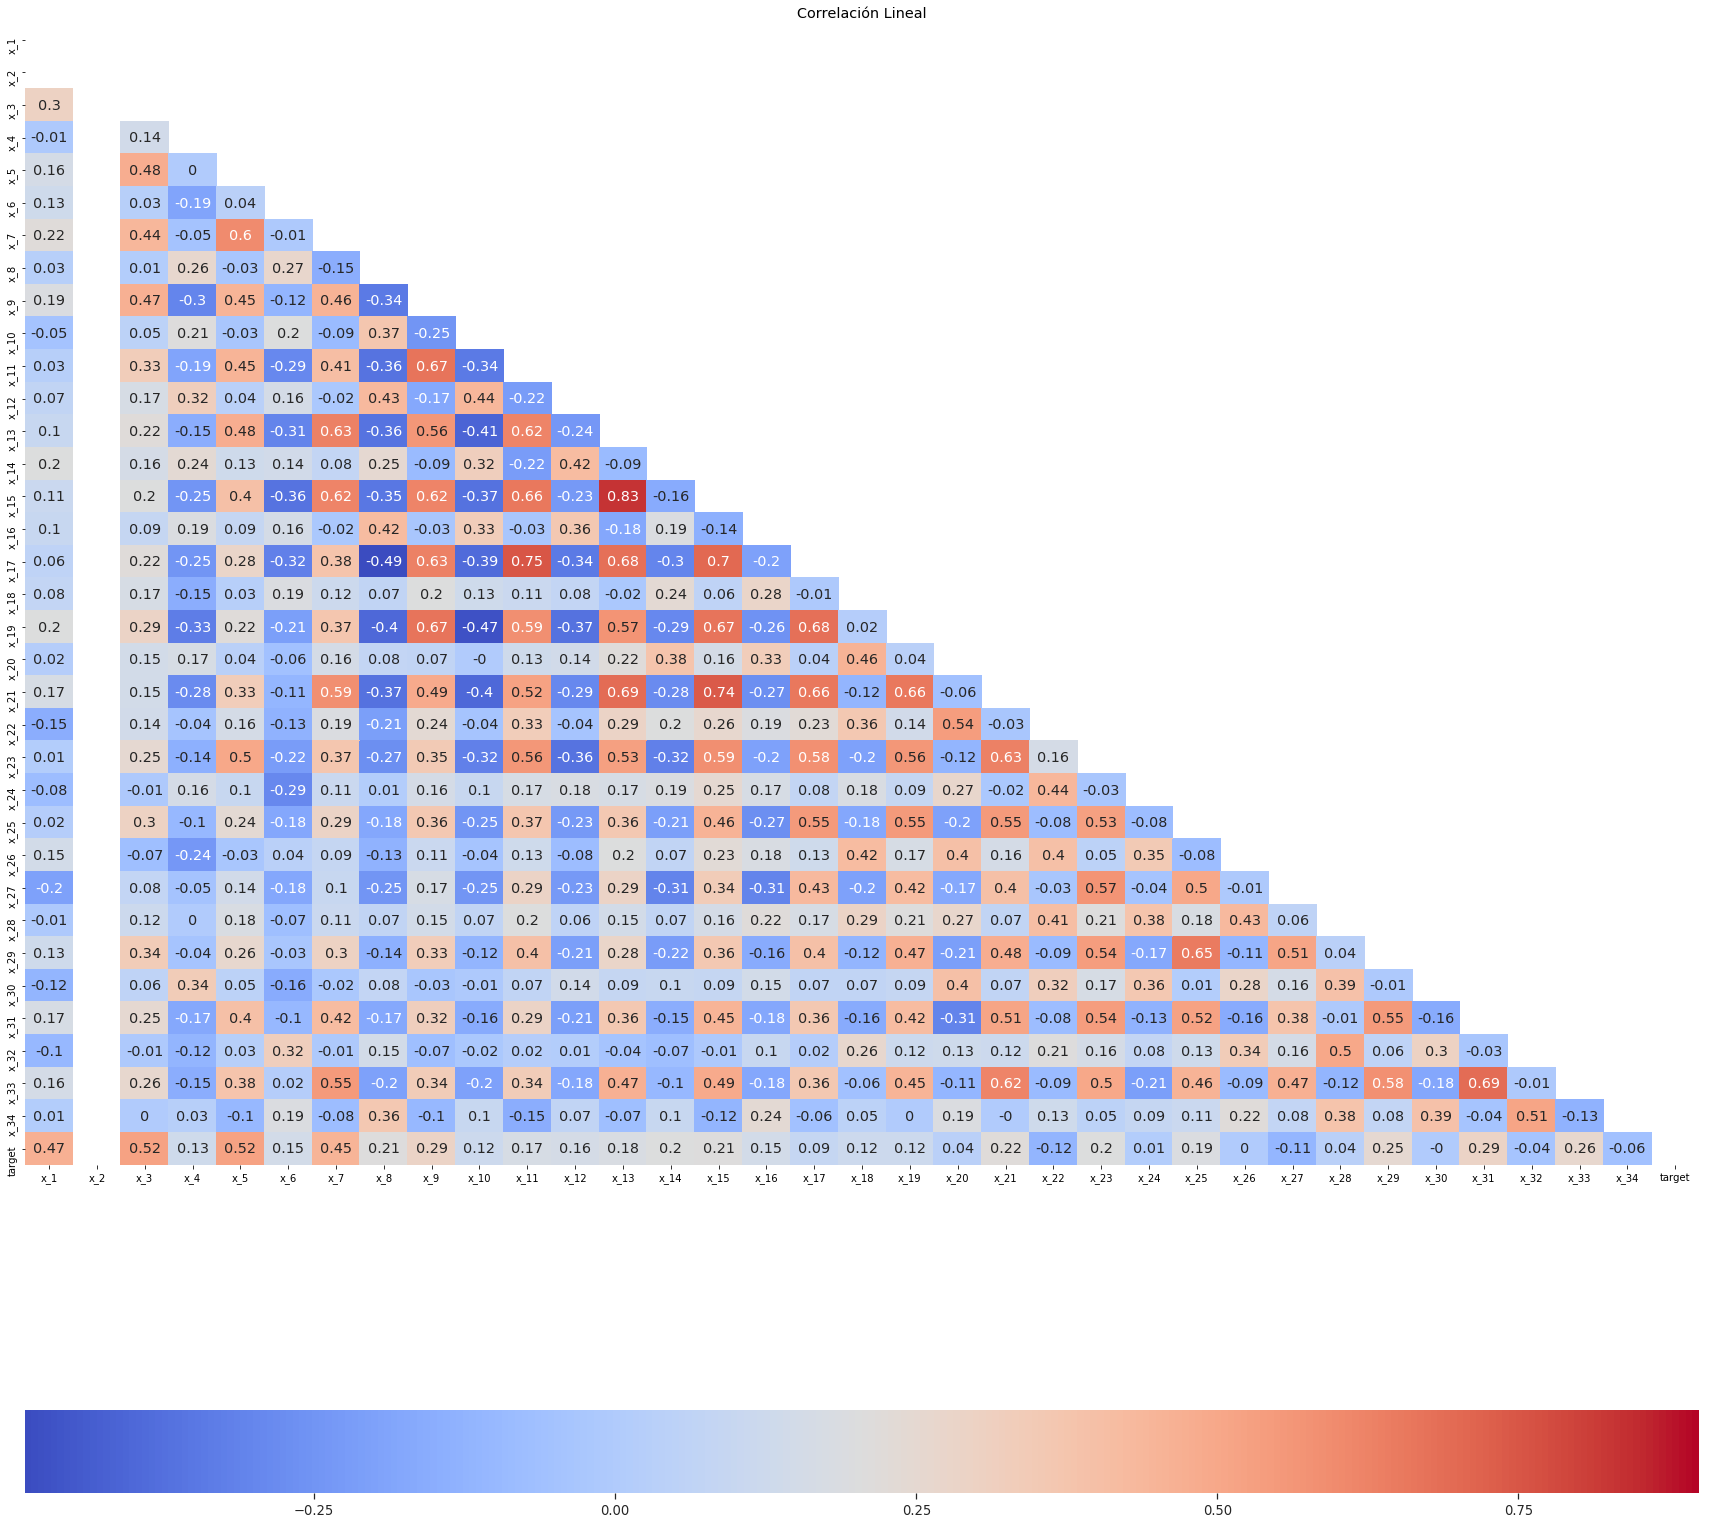

In [4]:
#Veamos las correlaciones
correlacion = df.corr()

#Mascara del mapa de calor
mascara = np.triu(np.ones_like(correlacion))

#Figura
fig, ax = plt.subplots(figsize=(30, 30))
sns.set(font_scale = 1.2)

#Mapa de calor
sns.heatmap(correlacion.round(2), vmax = 0.9, ax = ax, fmt = 'g',
            cmap = 'coolwarm', annot = True, mask = mascara, cbar_kws= {'orientation': 'horizontal'}) 

#Nombre grafico y plot
ax.set_title("Correlación Lineal")
plt.show()

In [5]:
#Transformamos dataset en 2 arreglos de numpy
X = df[df.columns[: -1]].to_numpy()
Y = df['target'].to_numpy()

Notamos que los valores de $x_2$ no tienen correlación con los demás valores, por ello los siguientes métodos se realizarán incluyendo el valor de este y otro sin incluirlo.

## Desarrollo del problema

##### 1.- Considere una sucesión creciente de parametros de penalización

In [6]:
rd.seed(21)
sucesion = list(set([0.01, 0.1, 1, 10, 100] + list(np.array(rd.sample(range(1, 100), 5)))))
sucesion.sort()
print(sucesion)

[0.01, 0.1, 1, 10, 22, 37, 54, 82, 89, 100]


##### 2.- Resuelva el problema de regresión logística con regularización considerando la penalización Ridge

Este problema se resolverá utilizando el método del gradiente, con paso de Armijo.

In [7]:
#------------------------------------------------------------------------------------------------
#------------------------------------ Funciones Principales ------------------------------------
#------------------------------------------------------------------------------------------------

def p0(x, w):
    '''
    Input:
        x = Vector en Rd de los datos administrados
        w = Parametro a estimar
        
    Output:
        probabilidad = Valor de la probabilidad del modelo parametrico 
                       evaluado en x y beta
    
    Esta funcion es el modelo parametrico de la funcion logistica
    '''
    #Valor del modelo parametrico
    probabilidad = 1 / (1 + exp(-1 * x.dot(w)[0]))
    
    #Cuidado con los log(0)
    if probabilidad == 1:
        probabilidad = probabilidad - 0.01
    
    elif probabilidad == 0:
        probabilidad = probabilidad + 0.01
    
    return probabilidad

#------------------------------------------------------------------------------------------------

def regresion_logistica(X, Y, w):
    '''
    Input:
        X = Matriz en Rpxd de observaciones del modelo
        Y = Vector de la clasificacion de las observaciones del modelo
        w = Parametro a estimar
        
    Output:
        F = Valor de la funcion de regresion logistica
    
    Esta funcion calcula el valor de la funcion de regresion logistica
    '''
    #Valor de la funcion
    F = 0
    
    #Dimension de X
    rows, _ = X.shape
    
    #Formamos la sumatoria
    for i in range(0, rows):
        
        #Sumatoria
        F = F + (Y[i] * ln(p0(X[i], w)) + (1 - Y[i]) * ln(1 - p0(X[i], w)))
    
    #Convexidad
    F = -1 * F
    
    return F

#------------------------------------------------------------------------------------------------

def dif_regresion_log(X, Y, w):
    '''
    Input:
        X = Matriz en Rpxd de observaciones del modelo
        Y = Vector de la clasificacion de las observaciones del modelo
        w = Parametro a estimar
        
    Output:
        DF = Gradiente de la funcion de regresion logistica
    
    Esta funcion calcula el gradiente de la funcion de regresion logistica
    '''
    #Dimension de X
    rows, cols = X.shape
    
    #Vector gradiente de la funcion
    DF = np.zeros(cols)
    
    #Sumatoria
    for i in range(0, rows):
        
        #Suma del vector
        DF = DF + X[i] * (Y[i] - p0(X[i], w))
        
    #Ajustamos dimension del arreglo y su convexidad
    DF = DF.reshape((cols,1))
    DF = -1 * DF
    
    return DF

#------------------------------------------------------------------------------------------------

In [8]:
#------------------------------------------------------------------------------------------------
#--------------------------- Metodo del Gradiente con paso de Armijo ---------------------------
#------------------------------------------------------------------------------------------------

def ridge(X, Y, w, lambdaa):
    '''
    Input:
        X = Matriz en Rpxd de observaciones del modelo
        Y = Vector de la clasificacion de las observaciones del modelo
        w = Parametro a estimar
        lambdaa = Penalizacion
        
    Output:
        F = Valor de la funcion de regresion logistica con penalizacion Ridge
    
    Esta funcion calcula el valor de la funcion de regresion logistica
    con penalizacion Ridge
    '''
    #Se obtiene la sumatoria del modelo ridge y la suma con la norma
    F = regresion_logistica(X, Y, w)
    
    F = F + lambdaa * (np.linalg.norm(w) ** 2)
    
    return F

#------------------------------------------------------------------------------------------------

def dif_ridge(X, Y, w, lambdaa):
    '''
    Input:
        X = Matriz en Rpxd de observaciones del modelo
        Y = Vector de la clasificacion de las observaciones del modelo
        w = Parametro a estimar
        lambdaa = Penalizacion
        
    Output:
        DF = Grafiente de la funcion de regresion logistica con penalizacion Ridge
    
    Esta funcion calcula el gradiente de la funcion de regresion logistica
    con penalizacion Ridge
    '''
    #Se obtiene la derivada de la primera parte de la funcion
    DF = dif_regresion_log(X, Y, w)
    
    #Luego se suma con la derivada de la norma
    DF = DF + 2 * lambdaa * w
    
    return DF

#------------------------------------------------------------------------------------------------

def gradiente_ridge(X, Y, lambdaa, epsilon, alfa, beta, itermax):
    '''
    Input:
        X = Matriz en Rpxd de observaciones del modelo
        Y = Vector de la clasificacion de las observaciones del modelo
        lambdaa = Penalizacion
        epsilon = Tolerancia maxima para la norma del gradiente de la
                  funcion logistica
        alfa = Valor para paso de Armijo
        beta = Valor para paso de Armijo
        itermax = Cantidad de iteraciones que se permite para el algoritmo
        
    Output:
        w = Estimacion del vector de parametros del modelo
    
    Esta funcion estima el vector de parametros del modelo de regresion
    logistica con penalizacion Ridge, utilizando el metodo del gradiente
    descendente con paso de Armijo
    '''
    #Dimensiones del dataframe
    row, col = X.shape
    
    #Se utiliza el vector 0 como valor inicial
    w = np.ones((col, 1)) * 0.5
    
    #Calculamos el gradiente de la funcion
    gk = dif_ridge(X, Y, w, lambdaa)
    norm_gk = np.linalg.norm(gk)
    
    #Contador
    k = 0
    
    #Condicion donde el diferencial debe acercarse a 0 o superar iteraciones
    while norm_gk >= epsilon and k <= itermax:
        
        #Se define la direccion a tomar y el beta para el paso Armijo
        dk = -1 * gk
        beta_k = beta
        
        #Valores para el paso de Armijo
        valor_k = ridge(X, Y, w + beta_k * dk, lambdaa) - ridge(X, Y, w, lambdaa)
        tolerancia_k = alfa * beta_k * dk.T.dot(gk)[0][0]
        
        #Si no se cumple la condicion de Armijo, seguimos hasta que se cumpla
        while valor_k > tolerancia_k:
            
            #Se actualiza el nuevo k para la potencia de beta que cumpla Armijo
            beta_k = beta_k * beta
            
            #Se actualizan los valores para la condicion de Armijo
            valor_k = ridge(X, Y, w + beta_k * dk, lambdaa) - ridge(X, Y, w, lambdaa)
            tolerancia_k = tolerancia_k * beta            

        #Se actualiza el valor de X con el mayor beta_k tal que cumple Armijo
        w = w + beta_k * dk
        
        #Se calcula el gradiente de la funcion con X actualizado
        gk = dif_ridge(X, Y, w, lambdaa)
        norm_gk = np.linalg.norm(gk)
        
        #Iteracion maxima
        k = k + 1
    
    return w.T

In [9]:
epsilon = 0.0001

b = gradiente_ridge(X, Y, 1, epsilon, 0.8, 0.8, 10000)

print('-------------------------------------------------------------')
print('Estimación del vector de parametros:\n', b)
print('-------------------------------------------------------------\n\n')

b = b.T

print('-------------------------------------------------------------')
print('Valor de la función logistica con penalizacion Ridge:\n', ridge(X, Y, b, 1))
print('-------------------------------------------------------------')
print('Valor norma del gradiente de la función logistica con penalizacion Ridge:\n', np.linalg.norm(dif_ridge(X, Y, b, 1)))
print('-------------------------------------------------------------')
print('Valor función logistica sin aditivo de penalizacion Ridge:\n', regresion_logistica(X,Y,b))
print('-------------------------------------------------------------')
print('Valor norma del gradiente de la función logistica sin aditivo de penalizacion Ridge:\n', np.linalg.norm(dif_regresion_log(X,Y,b)))

-------------------------------------------------------------
Estimación del vector de parametros:
 [[-5.59152840e-01  4.04353175e-05  1.22072302e+00  6.61443584e-01
   1.22423228e+00  6.32899464e-01  2.24911356e-01  8.36034627e-01
   5.08617733e-01 -1.29255882e-01 -7.78722485e-01 -2.66249278e-02
  -2.85814725e-01  6.06171531e-01  4.29884345e-01  4.83247129e-02
   2.10110797e-01  5.01519314e-01 -9.71932687e-02  8.55946238e-02
   1.63948963e-01 -1.44361028e+00  6.99143363e-01  3.26347851e-01
   4.41585815e-02  8.68847108e-01 -1.94369847e+00 -1.07889626e-01
   5.01099857e-01  1.98675858e-01  5.48994120e-01 -2.98669145e-01
   1.03768921e-01 -6.40325798e-01]]
-------------------------------------------------------------


-------------------------------------------------------------
Valor de la función logistica con penalizacion Ridge:
 128.6808415183334
-------------------------------------------------------------
Valor norma del gradiente de la función logistica con penalizacion Ridge:
 

##### 3.- Resuelva el problema de regresión logística con regularización considerando la penalización Lasso

Para este caso, se utilizará el método del gradiente proximal con paso de Armijo, donde la sucesion está dada por

$$x_{k+1} = prox_{\lambda ||\cdot||_1}(x_k - \alpha \nabla g(x_k))$$

donde $g$ es la función de regresión logística, que finalmente queda de la siguiente manera la sucesion

$$x_{k+1} = sign(x_k - \alpha \nabla g(x_k)) \cdot \max(|x_k - \alpha \nabla g(x_k)| - \alpha\lambda, 0)$$



In [10]:
#------------------------------------------------------------------------------------------------
#-------------------------------------- Gradiente Proximal --------------------------------------
#------------------------------------------------------------------------------------------------

def grad_prox_lasso(X, Y, lambdaa, alfa, beta, itermax, epsilon):
    '''
    Input:
        X = Matriz en Rpxd de observaciones del modelo
        Y = Vector de la clasificacion de las observaciones del modelo
        lambdaa = Penalizacion
        epsilon = Tolerancia maxima para la norma del gradiente de la
                  funcion logistica
        alfa = Valor para paso de Armijo
        beta = Valor para paso de Armijo
        itermax = Cantidad de iteraciones que se permite para el algoritmo
        
    Output:
        w = Estimacion del vector de parametros del modelo
    
    Esta funcion estima el vector de parametros del modelo de regresion
    logistica con penalizacion Lasso, utilizando el metodo del gradiente
    proximal
    '''
    #Dimensiones del dataframe
    row, col = X.shape
    
    #Se utiliza el vector 0 como valor inicial
    w = np.ones((col, 1)) * 0.5
    
    #Calculamos el gradiente de la funcion
    gk = dif_regresion_log(X, Y, w)
    norm_gk = np.linalg.norm(gk)
    
    #Contador
    k = 0
    
    #Condicion donde el diferencial debe acercarse a 0
    while norm_gk >= epsilon and k <= itermax:
    
        #Se define la direccion a tomar y el beta para el paso Armijo
        dk = -1 * gk
        beta_k = beta
        
        #Valores para el paso de Armijo
        valor_k = regresion_logistica(X, Y, w + beta_k * dk) - regresion_logistica(X, Y, w)
        tolerancia_k = alfa * beta_k * dk.T.dot(gk)[0][0]
        
        #Si no se cumple la condicion de Armijo, seguimos hasta que se cumpla
        while valor_k > tolerancia_k:
            
            #Se actualiza el nuevo k para la potencia de beta que cumpla Armijo
            beta_k = beta_k * beta
            
            #Se actualizan los valores para la condicion de Armijo
            valor_k = regresion_logistica(X, Y, w + beta_k * dk) - regresion_logistica(X, Y, w)
            tolerancia_k = tolerancia_k * beta

        #Se actualiza el valor de X con el mayor beta_k tal que cumple Armijo
        w = np.sign(w + beta_k * dk) * np.maximum(np.abs(w + beta_k * dk) - (lambdaa * beta_k), np.zeros((col, 1)))
        
        #Se calcula el gradiente de la funcion con X actualizado
        gk = dif_regresion_log(X, Y, w)
        norm_gk = np.linalg.norm(gk)
    
        #Cantidada maxima de iteraciones
        k = k + 1
    
    return w.T

In [11]:
b = grad_prox_lasso(X, Y, 1, 0.8, 0.8, 1000, epsilon)

print('-------------------------------------------------------------')
print('Estimación del vector de parametros:\n', b)
print('-------------------------------------------------------------\n\n')

b = b.T

print('-------------------------------------------------------------')
print('Valor función logistica sin aditivo de penalizacion Lasso:\n', regresion_logistica(X,Y,b))
print('-------------------------------------------------------------')
print('Valor norma del gradiente de la función logistica sin aditivo de penalizacion Lasso:\n', np.linalg.norm(dif_regresion_log(X,Y,b)))

-------------------------------------------------------------
Estimación del vector de parametros:
 [[-0.82575539  0.          1.68257447  0.72676498  1.667258    0.68522166
   0.          0.89328891  0.52860815 -0.01874583 -1.23805262 -0.
  -0.04483501  0.85679806  0.63463234 -0.          0.26851384  0.5643361
   0.          0.          0.         -2.08500608  1.04393105  0.42657176
  -0.          1.28642363 -2.70741644 -0.11204633  0.61482051  0.19269429
   0.59802122 -0.23518624  0.10738355 -0.82421731]]
-------------------------------------------------------------


-------------------------------------------------------------
Valor función logistica sin aditivo de penalizacion Lasso:
 106.58544894467224
-------------------------------------------------------------
Valor norma del gradiente de la función logistica sin aditivo de penalizacion Lasso:
 6.975430171302136


##### 4.- Gráfique

Ahora se hará el Cross-Validation para la estimación del valor $\lambda_l$ que minimice el error de predicción promedio, y luego se realizarán gráficos con $\hat{\beta}^{\lambda_l}$ vs $\{log \lambda_l\}_{l = 1}^K$.

In [12]:
#------------------------------------------------------------------------------------------------
#--------------------------- Calculo de Error de Prediccion Promedio ---------------------------
#------------------------------------------------------------------------------------------------

def error_pred_promedio(X_test, y_test, b):
    '''
    Inputs:
        X_test = Datos de Prueba
        Y_test = Clasificacion de Prueba
        b = Vector de parametros del modelo
    
    Output:
        error_prom = Valor del error de prediccion promedio
                     de la clasificacion y la prediccion dadas
    
    Esta funcion calcula el error de prediccion promedio
    '''
    #Dimensiones de los datos
    row, _ = X_test.shape
    
    #Lista de clasificacion
    y_pred = []
    
    for i in range(0, row):
        
        #Criterio de clasificación
        prob = p0(X_test[i], b)
        if prob >= 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
    
    #Calculo del error promedio
    error_prom = round(np.linalg.norm(np.array(y_pred) - y_test) ** 2, 6) / 10
    
    return error_prom

In [15]:
rd.seed(21)

#Lista al azar de los indices de los datos
lista = rd.sample(range(0, X.shape[0]), 100)

#Valores
largo_suc = len(sucesion)
alfa, beta = 0.8, 0.8
iteracion_max = 5000
epsilon = 0.00001
valores = []
vectores = []

#Cross-Validation
for i in range(0, largo_suc):
    
    list_temp = lista
    list_temp_test = list_temp[i * 10 : (i + 1) * 10]
    del list_temp[i * 10 : (i + 1) * 10]
    X_temp = X[list_temp]
    Y_temp = Y[list_temp]
    w_l = gradiente_ridge(X_temp, Y_temp, sucesion[i], epsilon, alfa, beta, iteracion_max)
    
    vectores.append(w_l)
    valores.append(error_pred_promedio(X[list_temp_test], Y[list_temp_test], w_l.T))

In [16]:
print('El valor de penalización que optimiza nuestro algoritmo de penalizacion Ridge es:')
print(f'lambda = {sucesion[valores.index(min(valores))]}')

El valor de penalización que optimiza nuestro algoritmo de penalizacion Ridge es:
lambda = 37



Grafico X = log(lambdas) vs Y = ||beta_lambda||_2


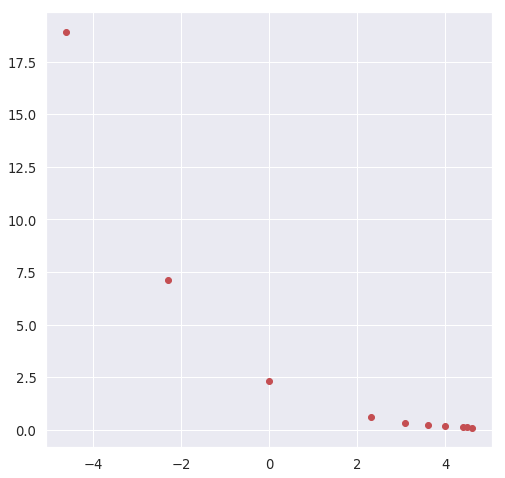

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

normas = [np.linalg.norm(vector) for vector in vectores]
lambdas = [ln(valor) for valor in sucesion]

print('\nGrafico X = log(lambdas) vs Y = ||beta_lambda||_2')

ax.plot(lambdas, normas, 'ro')
    
plt.show()


Graficos de Distribucion Estimaciones betas
lambda = 0.01
lambda = 0.1
lambda = 1
lambda = 10
lambda = 22
lambda = 37
lambda = 54
lambda = 82
lambda = 89
lambda = 100


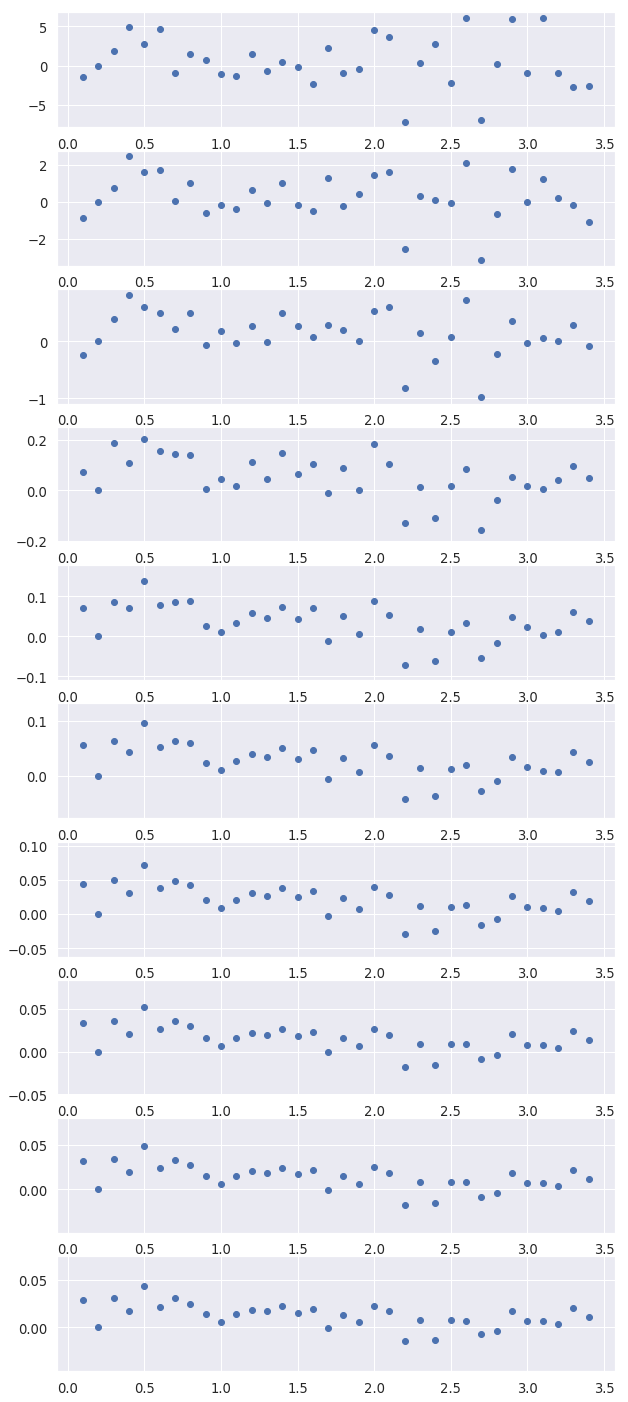

In [27]:
x = np.array(range(1, 35)) / 10

fig, ax = plt.subplots(10, 1, figsize = (10, 25))

print('\nGraficos de Distribucion Estimaciones betas')

for i in range(0, 10):
    
    print(f'lambda = {sucesion[i]}')
    ax[i].scatter(x, vectores[i])

plt.show()

In [28]:
valores = []
vectores = []

#Cross-Validation
for i in range(0, largo_suc):
    
    list_temp = lista
    list_temp_test = list_temp[i * 10 : (i + 1) * 10]
    del list_temp[i * 10 : (i + 1) * 10]
    X_temp = X[list_temp]
    Y_temp = Y[list_temp]
    w_l = grad_prox_lasso(X_temp, Y_temp, sucesion[i], alfa, beta, iteracion_max, epsilon)
    
    vectores.append(w_l)
    valores.append(error_pred_promedio(X[list_temp_test], Y[list_temp_test], w_l.T))

In [29]:
print('El valor de penalización que optimiza nuestro algoritmo de penalizacion Lasso es:')
print(f'lambda = {sucesion[valores.index(min(valores))]}')

El valor de penalización que optimiza nuestro algoritmo de penalizacion Lasso es:
lambda = 0.1



Grafico X = log(lambdas) vs Y = ||beta_lambda||_2


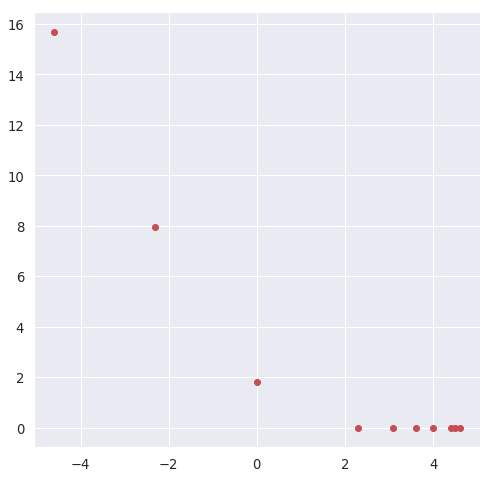

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

normas = [np.linalg.norm(vector) for vector in vectores]
lambdas = [ln(valor) for valor in sucesion]

print('\nGrafico X = log(lambdas) vs Y = ||beta_lambda||_2')

ax.plot(lambdas, normas, 'ro')
    
plt.show()


Graficos de Distribucion Estimaciones betas
lambda = 0.01
lambda = 0.1
lambda = 1
lambda = 10
lambda = 22
lambda = 37
lambda = 54
lambda = 82
lambda = 89
lambda = 100


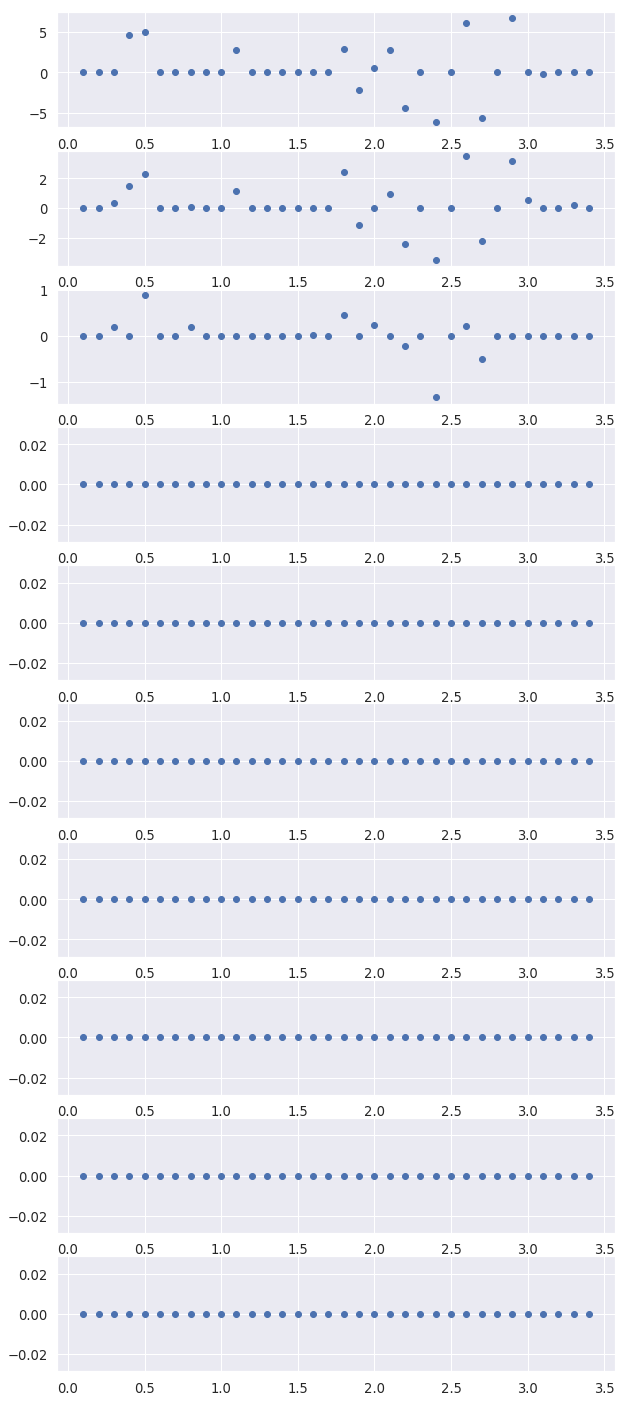

In [31]:
fig, ax = plt.subplots(10, 1, figsize = (10, 25))

print('\nGraficos de Distribucion Estimaciones betas')

for i in range(0, 10):
    
    print(f'lambda = {sucesion[i]}')
    ax[i].scatter(x, vectores[i])

plt.show()